In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import os

In [6]:
log_dir = "./ppo_cartpole_logs/"
os.makedirs(log_dir, exist_ok=True)
model_path = os.path.join(log_dir, "best_model")

In [7]:
env = make_vec_env("CartPole-v1", n_envs=4, monitor_dir=log_dir)

eval_env = make_vec_env("CartPole-v1", n_envs=1, monitor_dir=os.path.join(log_dir, "eval"))

model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1,
    tensorboard_log="./ppo_cartpole_tensorboard/",
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
)

stop_callback = StopTrainingOnRewardThreshold(reward_threshold=495, verbose=1)
eval_callback = EvalCallback(
    eval_env,
    callback_on_new_best=stop_callback,
    eval_freq=2000,
    n_eval_episodes=10,
    best_model_save_path=model_path,
    log_path=log_dir,
    verbose=1,
)


Using cpu device


Logging to ./ppo_cartpole_tensorboard/ppo_cartpole_run_1
Eval num_timesteps=8000, episode_reward=9.20 +/- 0.75
Episode length: 9.20 +/- 0.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.2      |
|    mean_reward     | 9.2      |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | 23       |
| time/              |          |
|    fps             | 2305     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=16000, episode_reward=314.40 +/- 185.81
Episode length: 314.40 +/- 185.81
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 314        |
|    mean_reward          | 314        |
| 

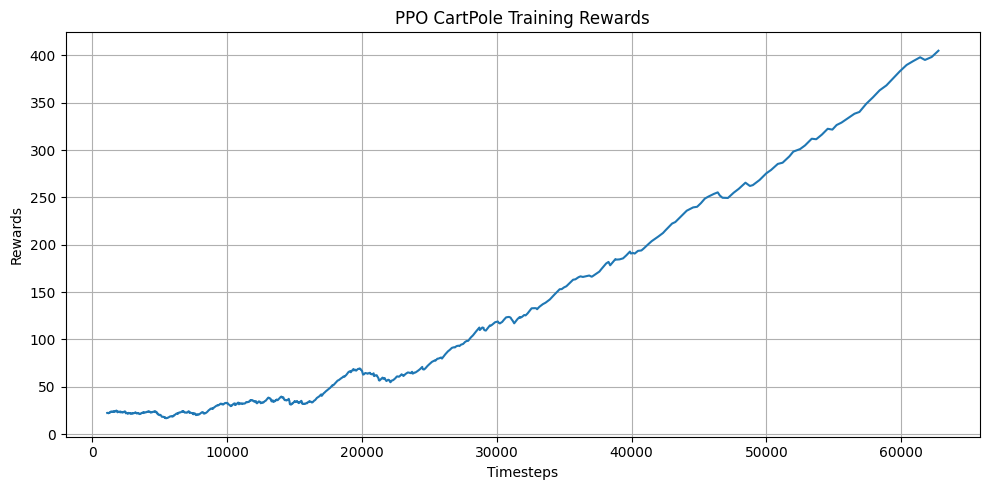

In [ ]:
model.learn(
    total_timesteps=100_000,
    callback=eval_callback,
    tb_log_name="ppo_cartpole_run"
)

final_model_path = os.path.join(log_dir, "final_model")
model.save(final_model_path)
print(f"Model saved to {final_model_path}")

def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_training_results(log_folder, title='Learning Curve'):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    
    x = x[len(x) - len(y):]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, y)
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Rewards')
    ax.set_title(title)
    ax.grid(True)
    plt.tight_layout()
    return fig, ax

plot_training_results(log_dir, title='PPO CartPole Training Rewards')
plt.show()

In [24]:
# ===== Testing Phase =====
# Load the best model for testing
print("Loading best model for testing...")
if os.path.exists(os.path.join(model_path, "best_model.zip")):
    best_model = PPO.load(os.path.join(model_path, "best_model"))
else:
    print("Best model not found, using final model")
    best_model = PPO.load(final_model_path)

# Test the model
test_env = gym.make("CartPole-v1")
episode_rewards = []
num_test_episodes = 50

for episode in range(num_test_episodes):
    obs = test_env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # Convert observation to numpy array if it's not already
        if isinstance(obs, tuple):
            # For gym environments >=0.26.0 that return (obs, info) from reset()
            obs = obs[0]
        
        # Ensure obs is a numpy array with the right shape
        if not isinstance(obs, np.ndarray):
            obs = np.array(obs)
        
        if len(obs.shape) == 1:
            obs = obs.reshape(1, -1)
            
        action, _ = best_model.predict(obs, deterministic=True)
        
        # Extract scalar action for the non-vectorized environment
        if hasattr(action, "__len__"):
            action = action[0]
            
        obs, reward, done, _ ,_ = test_env.step(action)
        
        # Handle new gym API that might return truncated
        if isinstance(done, tuple):
            done = done[0]
        
        total_reward += reward
        # test_env.render()
    
    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

test_env.close()

Loading best model for testing...
Episode 1: Total Reward = 1172.0
Episode 2: Total Reward = 532.0
Episode 3: Total Reward = 3282.0
Episode 4: Total Reward = 1928.0
Episode 5: Total Reward = 597.0
Episode 6: Total Reward = 2139.0
Episode 7: Total Reward = 6227.0
Episode 8: Total Reward = 1394.0
Episode 9: Total Reward = 786.0
Episode 10: Total Reward = 1378.0
Episode 11: Total Reward = 1544.0
Episode 12: Total Reward = 1652.0
Episode 13: Total Reward = 1554.0
Episode 14: Total Reward = 729.0
Episode 15: Total Reward = 1602.0
Episode 16: Total Reward = 563.0
Episode 17: Total Reward = 1926.0
Episode 18: Total Reward = 5406.0
Episode 19: Total Reward = 1667.0
Episode 20: Total Reward = 6494.0
Episode 21: Total Reward = 1618.0
Episode 22: Total Reward = 1883.0
Episode 23: Total Reward = 830.0
Episode 24: Total Reward = 2883.0
Episode 25: Total Reward = 5876.0
Episode 26: Total Reward = 580.0
Episode 27: Total Reward = 555.0
Episode 28: Total Reward = 2705.0
Episode 29: Total Reward = 1325

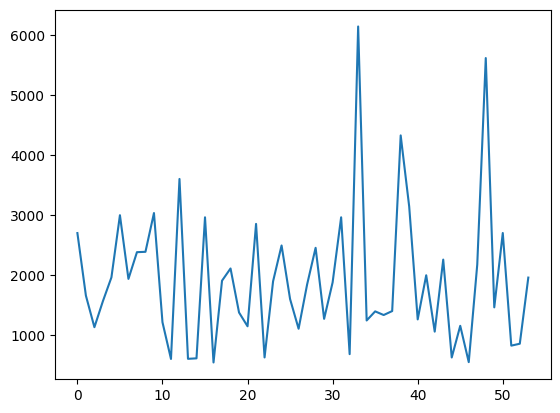

In [23]:
plt.plot(episode_rewards)